In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('model.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sim_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,comment_duplication,is_spam
0,0,0.265993,0.239773,1.402189,0.000000,1,3.137146,0.0,0,0.0,39.978929,0.200000,0,0,0,0.0,0
1,1,0.327118,0.222346,2.769147,0.000000,1,4.905188,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0
2,2,0.433986,0.309582,3.532625,0.032258,1,5.719015,0.0,0,0.0,39.978929,0.064516,0,0,0,0.0,0
3,3,0.201988,0.181141,1.818371,0.000000,1,3.770442,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0
4,4,0.176259,0.125743,1.402189,0.000000,1,3.011349,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sim_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'comment_duplication', 'is_spam'],
      dtype='object')

In [5]:
dfc = df.copy()

In [6]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from collections import Counter
print("The number of classes before fit {}".format(Counter(y_train)))

The number of classes before fit Counter({0: 7865, 1: 643})


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [10]:
model = LogisticRegression()


solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1','elasticnet','none']
c_values = [100, 10, 1.0, 0.1, 0.01,0.001,0.0001]
dual = [True,False]
fit_intercept = [True,False]
warm_start = [True,False]

grid = dict(solver=solvers,penalty=penalty,C=c_values,dual=dual,fit_intercept=fit_intercept,warm_start=warm_start)

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='average_precision',error_score=0,return_train_score=True,verbose=2)
xgb_random.fit(X_train,y_train)
print(xgb_random.best_score_)
best_model = xgb_random.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.770094738672579


C:\Users\Acer\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


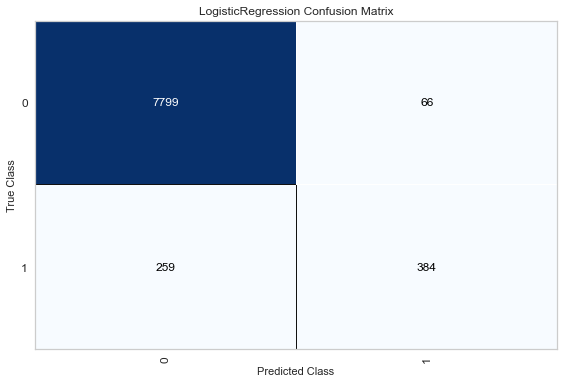

In [11]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(best_model, cmap='Blues')
cm.score(X_train, y_train)
cm.show();

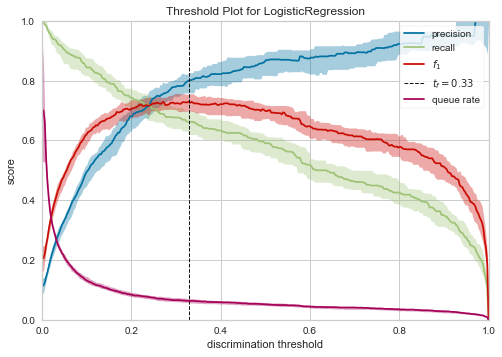

In [12]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(best_model, quantiles=np.array([0.25, 0.5,0.75]))

visualizer.fit(X_train, y_train)
visualizer.show(); 

In [13]:
from sklego.meta import Thresholder

best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]

In [14]:
best_threshold

0.3284457478005865

In [23]:
from sklearn.pipeline import make_union, make_pipeline
#pipe = make_pipeline(*best_model[:-1], Thresholder(best_model[1], best_threshold))
#pipe.fit(X_train, y_train);

### you can change the threshold manually like below

In [28]:
THRESHOLD = 0.6
y_pred = np.where(best_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1948   10]
 [  82   87]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1958
           1       0.90      0.51      0.65       169

    accuracy                           0.96      2127
   macro avg       0.93      0.75      0.82      2127
weighted avg       0.95      0.96      0.95      2127

